In [3]:
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image


prompt = "A dog stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
image_path = "./images/dog.jpg"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 4

model = StableDiffusion()
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize((512, 512))])

output = model.generate(input_image=input_image,
                        prompt=prompt,
                        uncond_promt=uncond_prompt,
                        do_cfg=do_cfg,
                        cfg_scale=cfg_scale,
                        device='mps',
                        strength=strength,
                        inference_steps=num_inference_steps,
                        transforms=transform,
                        tokenizer=CLIPTokenizer('./weights/clip/tokenizer_vocab.json', merges_file='./weights/clip/tokenizer_merges.txt')
                       )


torch.Size([1, 1024, 64, 64])
torch.Size([1, 4096, 1024])


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.67it/s]


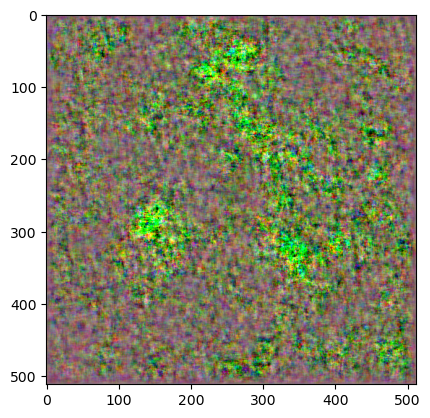

In [4]:
from matplotlib import pyplot as plt
plt.imshow(output)